In [13]:
from pyproj import Transformer
from dotenv import load_dotenv
import os
load_dotenv()

def convert_utm_to_wgs84(utm_x, utm_y):
    # Define the transformer: from UTM zone 19S (EPSG:32719) to WGS 84 (EPSG:4326)
    transformer = Transformer.from_crs("EPSG:32719", "EPSG:4326", always_xy=True)

    # Convert to latitude and longitude
    lon, lat = transformer.transform(utm_x, utm_y)

    return lon, lat


{'north': -9.54, 'south': -10.14, 'east': -66.869, 'west': -67.469}
Saved raster tile to /Users/samuelxu/dev/oaiarch/tile.tif


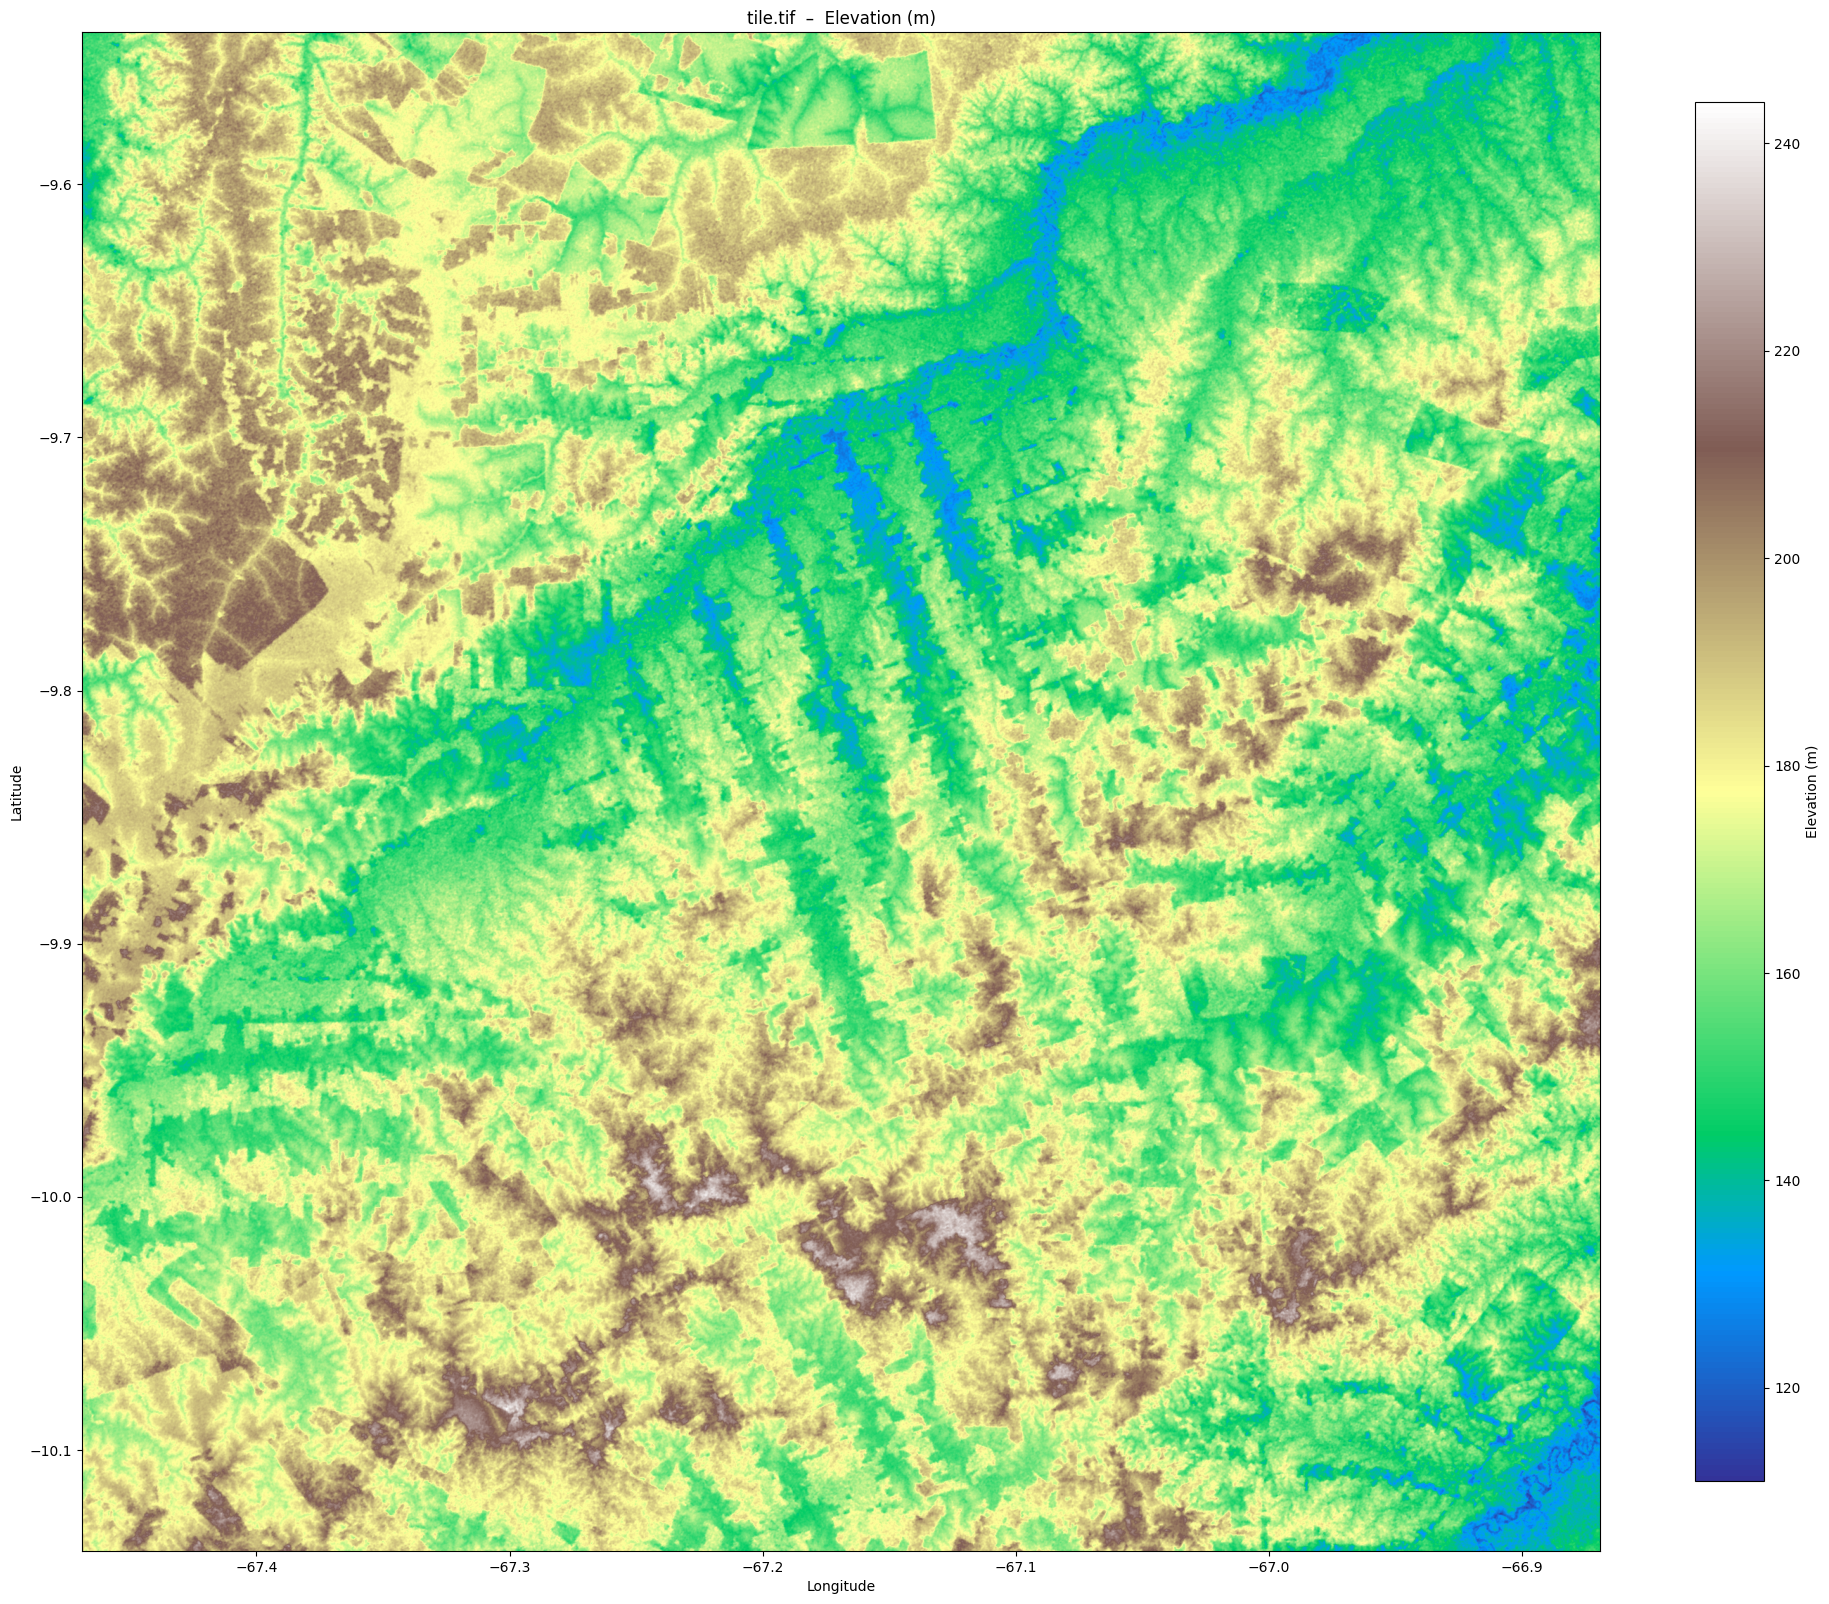

In [14]:
"""
Download a GeoTIFF tile from OpenTopography and display it.

Dependencies
------------
pip install requests rasterio matplotlib
"""
from __future__ import annotations

import io
import sys
import zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import rasterio
import requests


def fetch_raster_tile_from_opentopography(
    api_key: str,
    dataset: str,
    north: float,
    south: float,
    east: float,
    west: float,
    dest: Path = Path("tile.tif"),
    source: str = "globaldem"
) -> Path:
    """
    Download a GeoTIFF tile from OpenTopography’s Point-Cloud API.

    Returns
    -------
    Path
        Path to the downloaded `.tif` file (possibly extracted from a ZIP).
    """
    outputFormat = "GTiff"
    ds_key = ""
    if source == "usgsdem":
        ds_key = "datasetName"
    elif source == "globaldem":
        ds_key = "demtype"
    else:
        raise ValueError(f"Invalid source: {source}")
    url = f"https://portal.opentopography.org/API/{source}?{ds_key}={dataset}&north={str(north)}&south={str(south)}&east={str(east)}&west={str(west)}&outputFormat={outputFormat}&API_Key={api_key}"

    # print("Requesting data from ", url)

    r = requests.get(url,  timeout=300)
    if (len(r.content) < 200):
        print(r.content)
    r.raise_for_status()

    # The service may send back either a bare .tif or a ZIP archive.
    content_type = r.headers.get("content-type", "")
    if "zip" in content_type or r.content[:2] == b"PK":
        with zipfile.ZipFile(io.BytesIO(r.content)) as zf:
            tif_name = next(n for n in zf.namelist() if n.lower().endswith(".tif"))
            zf.extract(tif_name, dest.parent)
            dest = dest.parent / tif_name
    else:
        dest.write_bytes(r.content)

    print(f"Saved raster tile to {dest.resolve()}")
    return dest


def display_raster(path: Path) -> None:
    """Render the GeoTIFF elevation raster with matplotlib."""
    with rasterio.open(path) as src:
        data = src.read(1, masked=True)  # first band
        bounds = src.bounds

    fig, ax = plt.subplots(figsize=(20, 20))
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
    im = ax.imshow(
        data, cmap="terrain", extent=extent, origin="upper"
    )
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"{path.name}  –  Elevation (m)")
    cbar = fig.colorbar(im, ax=ax, shrink=0.7)
    cbar.set_label("Elevation (m)")
    plt.tight_layout()
    plt.show()

api_key = os.environ.get("OPENTOPOGRAPHY_API_KEY")

# Example parameters; change these to suit your AOI
boa_espar = (700753,	8911712	)
center = convert_utm_to_wgs84(boa_espar[0], boa_espar[1])
center = (center[0].__round__(3), center[1].__round__(3))
# center = (40.0,15.0)
radius = 0.3
east = center[0] + radius
west = center[0] - radius
north = center[1] + radius
south = center[1] - radius
print({
    "north": north,
    "south": south,
    "east": east,
    "west": west
})
dataset = "SRTMGL1"

out_path_1 = fetch_raster_tile_from_opentopography(api_key, dataset, north, south, east, west, source="globaldem")
display_raster(out_path_1)
# out_path_2 = fetch_raster_tile(api_key, dataset, north+0.1, south, east, west)
# display_raster(out_path_2)

In [15]:
from typing import Tuple
import base64
from openai import OpenAI
import os

def raster_to_png_data_url(
    tif_path: Path, size: Tuple[int, int] = (512, 512)
) -> str:
    """
    Down-sample the first band of the GeoTIFF, scale to 8-bit, and
    return a data-URL (PNG, base-64) suitable for the OpenAI vision API.
    """
    with rasterio.open(tif_path) as src:
        data = src.read(1, masked=True).astype(np.float32)

    # Simple min-max stretch → 0-255
    z_min, z_max = np.nanmin(data), np.nanmax(data)
    arr = np.clip((data - z_min) / (z_max - z_min + 1e-9) * 255, 0, 255).astype(
        np.uint8
    )

    # Resize to something manageable for the API
    fig = plt.figure(frameon=False)
    fig.set_size_inches(*[s / 100 for s in size])
    ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(arr, cmap="gray", origin="upper")
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=100)
    plt.close(fig)

    png_base64 = base64.b64encode(buf.getvalue()).decode("ascii")
    return f"data:image/png;base64,{png_base64}"

def analyse_with_openai(
    image_data_url: str,
    prompt: str = "Describe the major terrain / geomorphological features visible in this elevation raster.",
    model: str = "o4-mini",
    max_tokens: int = 400,
) -> str:
    """
    Send an image + prompt to GPT-4o’s vision endpoint and return the text.
    """
    client = OpenAI()  # picks up OPENAI_API_KEY from env
    print("→ Contacting OpenAI …")
    completion = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": image_data_url, "detail": "high"}},
                ],
            }
        ],
        # max_tokens=max_tokens,
    )
    return completion.choices[0].message.content.strip()

data_url = raster_to_png_data_url(out_path_1)

analysis = analyse_with_openai(data_url)

→ Contacting OpenAI …


In [17]:
print(analysis)

The scene is dominated by a classic ridge-and-valley landscape underlain by resistant and less-resistant rock layers, with a well-developed dendritic drainage network cutting into it.  Here are the main features you can pick out:  

• Parallel, elongate ridges  
  – They run roughly NW–SE (upper left toward lower right of the image).  
  – High, lighter tones on their crests and steeper, shadowed flanks.  
  – Likely folded or fault-bound strata giving that regular “ribbed” appearance.  

• Steep V-shaped valleys and hollows  
  – Darker, narrow channels between the ridges.  
  – Many small tributaries feeding into larger trunk streams.  
  – Characteristic dendritic (tree-like) pattern indicative of relatively uniform bedrock.  

• Alluvial/terrace plains and agricultural bench areas  
  – In the upper right quadrant you see broad, low-relief patches in a checkerboard of rectangular shades—these are valley floors or river terraces under cultivation.  
  – Their straight edges contrast

In [19]:
import laspy
import numpy as np
import plotly.graph_objects as go

# Load the LAZ file
las = laspy.read("ex1.laz")

# Extract coordinates
x = las.x
y = las.y
z = las.z

# Optional: downsample for performance
sample_indices = np.random.choice(len(x), size=min(100000, len(x)), replace=False)
x = x[sample_indices]
y = y[sample_indices]
z = z[sample_indices]

# Optional: use color if available
if hasattr(las, 'red') and hasattr(las, 'green') and hasattr(las, 'blue'):
    r = las.red[sample_indices] / 65535.0
    g = las.green[sample_indices] / 65535.0
    b = las.blue[sample_indices] / 65535.0
    colors = ['rgb({},{},{})'.format(int(r[i]*255), int(g[i]*255), int(b[i]*255)) for i in range(len(r))]
else:
    colors = z  # Color by height

# Create Plotly 3D scatter plot
fig = go.Figure(data=[
    go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(
            size=1.5,
            color=colors,  # Either RGB or scalar z values
            colorscale='Viridis' if isinstance(colors[0], (float, np.float64)) else None,
            opacity=0.8
        )
    )
])

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
    ),
    title="LAZ Point Cloud",
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()
